## ExMAS
> Equilibrium matching


In [1]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching
from ExMAS.extras import games, pricings, prunings, pipeline

In [4]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/pipe.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
params.nP = 50
params.simTime = 0.1
params.shared_discount = 0.3
inData = ExMAS.utils.generate_demand(inData, params)  # generate requests

In [5]:
inData = ExMAS.main(inData, params, plot = False)
KPIs = inData.sblts.res.to_frame('u_pax')
inData = games.prepare_PoA(inData)  # prepare data structures

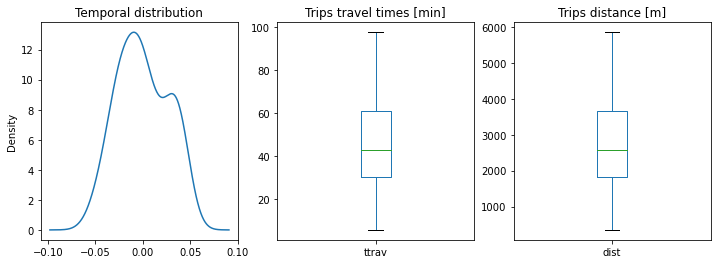

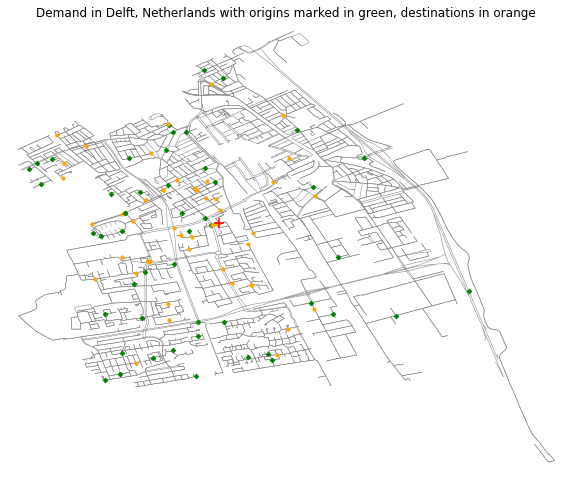

In [6]:
ExMAS.utils.plot_demand(inData, params)

### incidence matrix
rows are trips columns are rides,
1 if trip blongs to a ride, 0 otherwise

light - feasible | blue - pruned | dark - selected


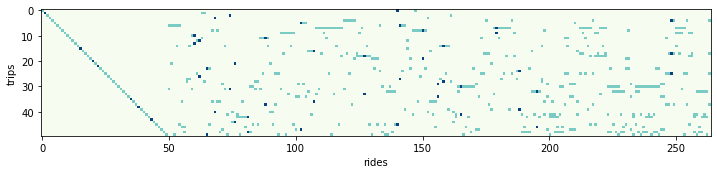

In [7]:
def plot_im(inData):
    mtx = np.vstack(inData.sblts.rides['row'].values).T  # creates a numpy array for the constrains
    m = pd.DataFrame(mtx).astype(int)
    plt.rcParams['figure.figsize'] = [12, int(12*inData.sblts.rides.shape[0]/inData.requests.shape[0])]
    m.index.name = 'trips'
    m.columns.name = 'rides'
    inData.sblts.m = m
    m_solution = m.copy()
    fig, ax = plt.subplots()
    for col in m.columns:
        if inData.sblts.rides.loc[col].selected==0:
            if inData.sblts.rides.loc[col].pruned == True:
                m_solution[col] = 0.5*m[col]
            else:
                m_solution[col] = 0.2*m[col]
        else:
            m_solution[col] = m[col]
    
    from matplotlib import colors
    cmap = colors.ListedColormap(['white', 'grey', 'blue','black'])
    cmap = 'GnBu'
    ax.imshow(m_solution, cmap=cmap, interpolation = 'Nearest')
    ax.set_ylabel('trips')
    _ = ax.set_xlabel('rides')
    print('light - feasible | blue - pruned | dark - selected')
plot_im(inData)

### pricing

eq. 1 , eq.2

In [8]:

params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0 # fixed penalty (EUR) per 

params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0.5 # ride fixed costs (per vehicle)

In [9]:
inData = games.prepare_PoA(inData)

In [10]:
def update_costs(inData, params):
    rm = inData.sblts.rides_multi_index
    rm['distance'] = rm.ride_time*params.avg_speed

    rm['cost_veh'] = params.veh_cost*rm['distance'] + params.fixed_ride_cost
    rm['cost_user'] = params.time_cost * rm.ttrav_sh + \
                         params.wait_cost * abs(rm.delay) + \
                         params.sharing_penalty_fixed * rm.shared + \
                         params.sharing_penalty_multiplier * rm.shared * rm.ttrav_sh

    inData.sblts.rides['costs_user'] = rm.groupby('ride').sum()['cost_user']
    inData.sblts.rides['costs_veh'] = rm.groupby('ride').max()['cost_veh']

    rm['cost_single'] = rm.apply(
        lambda r: rm[(rm.traveller == r.traveller) & (rm.shared == False)]['cost_user'].max(), axis=1)

    inData.sblts.rides_multi_index = rm

    return inData
inData = update_costs(inData, params)
inData.sblts.rides_multi_index.tail(9)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
261 42   261         42    True       3   259       837  2969    371   
    41   261         41    True       3   258       837  1832    229   
262 32   262         32    True       3   210       902  4456    557   
    42   262         42    True       3   259       902  2969    371   
    49   262         49    True       3   340       902  2606    325   
263 17   263         17    True       4   119       607  3566    445   
    4    263          4    True       4    20       607  2204    275   
    25   263         25    True       4   172       607  1578    197   
    37   263         37    True       4   227       607  1528    191   

        ttrav_sh  delay distance cost_veh  cost_user  cost_single  
261 42       422   59.0     6696  4.30835    1.78675       1.2985  
    41       491  254.0     6696  4.30835    3.05200       0.8015  
262 32       823  -44.0     7216   4.6041    3.11150       1.9495  
    42       671   59.0     7216   4.6041    2.65825       1.2985  
    49       345  383.0     7216   4.6041    3.21825       1.1375  
263 17       607  -74.0     4856  3.26185    2.51300       1.5575  
    4        308   89.0     4856  3.26185    1.54525       0.9625  
    25       452   28.0     4856  3.26185    1.72900       0.6895  
    37       345   80.0     4856  3.26185    1.62750       0.6685

### uniform split

In [11]:
inData = pricings.uniform_split(inData) 
rs = inData.sblts.rides.sample(4).index
inData.sblts.rides_multi_index.loc[rs,:]

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
4   4      4          4   False       1    20       275  2204    275   
11  11    11         11   False       1    60       277  2223    277   
54  6     54          6    True       2    23       939  3169    396   
    45    54         45    True       2   265       939  3687    460   
113 7    113          7    True       2    27       516  3351    418   
    25   113         25    True       2   172       516  1578    197   

        ttrav_sh  delay distance cost_veh  cost_user  cost_single  \
4   4        275    0.0     2200  1.75125   0.962500       0.9625   
11  11       277    0.0     2216  1.76035   0.969500       0.9695   
54  6        410  -47.5     7512  4.77245   1.684375       1.3860   
    45       572   62.5     7512  4.77245   2.330125       1.6100   
113 7        433  -53.0     4128   2.8478   1.793750       1.4630   
    25       235   68.0     4128   2.8478   1.179500       0.6895   

        uniform_split  
4   4        2.713750  
11  11       2.729850  
54  6        4.393475  
    45       4.393475  
113 7        2.910525  
    25       2.910525

In [12]:
inData.sblts.rides.loc[rs][['costs_veh','costs_user']].sort_index()

,costs_veh,costs_user
4,1.75125,0.96250
11,1.76035,0.96950
54,4.77245,4.01450
113,2.84780,2.97325


In [13]:
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='EXMAS').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
EXMAS,15352,20189,0.86,85.2166,84.8155


# Algorithms

In [14]:
inData.results.rides = inData.sblts.rides.copy()  # copy tables to collect results
inData.results.rm = inData.sblts.rides_multi_index.copy()
inData.results.KPIs = dict()

### TNE 
$c_i({i})>=c_i(G)$

only rides for which all users have lower costs than single (similar to ExMAS)

11-12-20 09:45:52-WARNING-Pruned nRides 80/264
11-12-20 09:45:52-WARNING-uniform_split-TNE-u_veh-min
light - feasible | blue - pruned | dark - selected


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
TNE,15876,19283,0.32,93.0771,70.5906


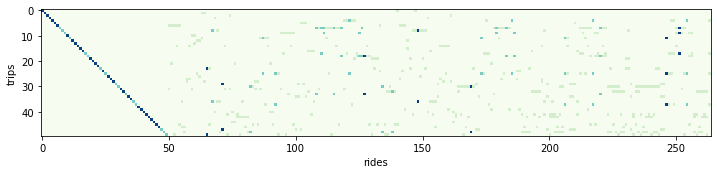

In [15]:
params.multi_platform_matching = True
params.assign_ride_platforms = False
inData = pipeline.single_eval(inData, params, prunings.algo_TNE, PRICING = 'uniform_split', ALGO = 'TNE', objs = ['u_veh'],minmax = ['min'], store_res = False)
plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

### HERMETIC 


only Hermetic groups are left in the search space

Subgroup H of Group G is not hermetic if somoeone wants to leave H for G

11-12-20 09:45:54-WARNING-Pruned nRides 66/264
11-12-20 09:45:54-WARNING-uniform_split-HERMETIC-u_veh-min
light - feasible | blue - pruned | dark - selected


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
TNE,16045,19204,0.3,94.4142,70.5784


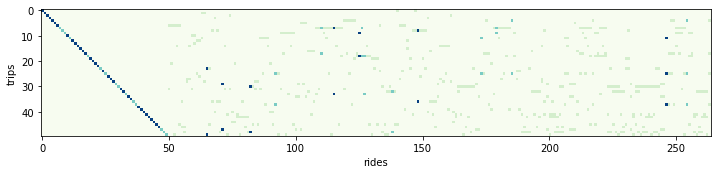

In [16]:
inData = pipeline.single_eval(inData, params, prunings.algo_HERMETIC, PRICING = 'uniform_split', ALGO = 'HERMETIC', objs = ['u_veh'],minmax = ['min'], store_res = False)
plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

### RUE 

two megreable groups cannot be together in the solution (if everyone is better-off in $G_1 \cup G_2$ when group $G_1$ and $G_2$ are merged)

11-12-20 09:45:57-WARNING-Pruned nRides 264/264
11-12-20 09:45:57-WARNING-uniform_split-RUE-u_veh-min
11-12-20 09:45:57-WARNING-Adding 74 mutually exlcusive constrains
light - feasible | blue - pruned | dark - selected


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
TNE,13438,20661,0.76,75.8254,93.5786


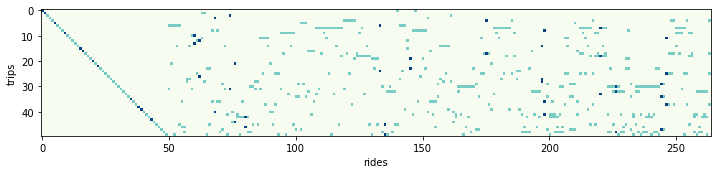

In [17]:
inData = pipeline.single_eval(inData, params, prunings.algo_RUE, PRICING = 'uniform_split', ALGO = 'RUE', objs = ['u_veh'],minmax = ['min'], store_res = False)
plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

### RSIE 

two *unstable* groups cannot be together in the solution 

if anyone from $G1$ wants to join $G2$ and it is better for the moving traveller and group accepting him.

11-12-20 09:45:58-WARNING-Searching unstable pairs 0/264. 0 found so far
11-12-20 09:46:07-WARNING-Searching unstable pairs 20/264. 199 found so far
11-12-20 09:46:16-WARNING-Searching unstable pairs 40/264. 381 found so far
11-12-20 09:46:25-WARNING-Searching unstable pairs 60/264. 530 found so far
11-12-20 09:46:32-WARNING-Searching unstable pairs 80/264. 568 found so far
11-12-20 09:46:38-WARNING-Searching unstable pairs 100/264. 643 found so far
11-12-20 09:46:45-WARNING-Searching unstable pairs 120/264. 700 found so far
11-12-20 09:46:52-WARNING-Searching unstable pairs 140/264. 747 found so far
11-12-20 09:46:58-WARNING-Searching unstable pairs 160/264. 788 found so far
11-12-20 09:47:04-WARNING-Searching unstable pairs 180/264. 850 found so far
11-12-20 09:47:10-WARNING-Searching unstable pairs 200/264. 924 found so far
11-12-20 09:47:15-WARNING-Searching unstable pairs 220/264. 924 found so far
11-12-20 09:47:20-WARNING-Searching unstable pairs 240/264. 924 found so far
11-12-2

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
TNE,13443,20586,0.78,75.9847,94.2821


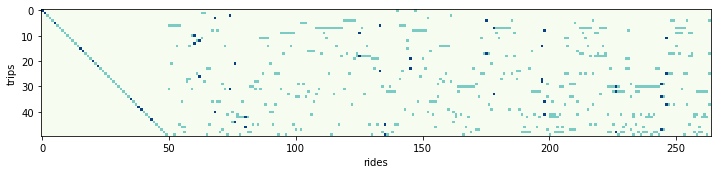

In [18]:
inData = pipeline.single_eval(inData, params, prunings.algo_RSIE, PRICING = 'uniform_split', ALGO = 'RSIE', objs = ['u_veh'],minmax = ['min'], store_res = False)
plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

### TSE 

strongest notion, explored heuristically

best groups are selected, based on their cost per user.

11-12-20 09:47:29-WARNING-Pruned nRides 264/264
light - feasible | blue - pruned | dark - selected


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
TNE,16282,20586,0.3,95.4926,69.1819


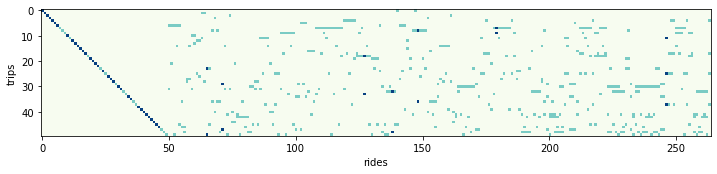

In [19]:
inData = pipeline.single_eval(inData, params, prunings.algo_TSE, PRICING = 'uniform_split', ALGO = 'TSE', objs = ['u_veh'],minmax = ['min'], store_res = False)
plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T


---
# Bigger experiment

* 300 travellers
* uniform pricing
* 5 algorithms + window based
* matching_objs: 
    * user + veh
    * veh
* directions:
    * min (Best Price of Anarchy)
    * max (Worst Price of Anarchy)

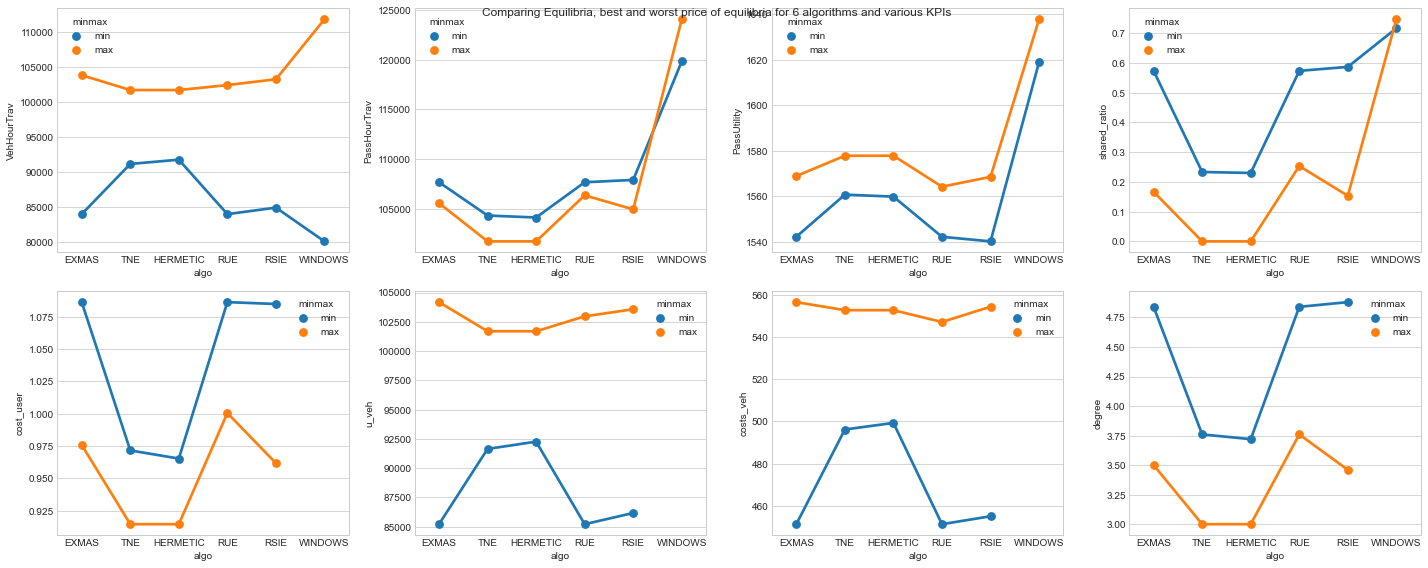

In [20]:
def plot_KPIs(obj = 'costs_veh'):
    plt.style.use('seaborn-whitegrid')
    KPIs = pd.read_csv('ExMAS/extras/PIPE_KPIs.csv', index_col = 0)
    KPIs = KPIs[~(KPIs.algo == 'TSE')]
    KPIs.obj = KPIs.obj.apply(lambda x: 'costs_user' if x == 'u_pax' else x)
    KPIs.obj = KPIs.obj.apply(lambda x: 'costs_veh' if x == 'u_veh' else x)
    to_plot = KPIs[(KPIs.obj == obj)]
    fig, axes = plt.subplots(2,4,figsize = (20,8))
    axes = axes.flatten()
    sns.pointplot(y='VehHourTrav',x = 'algo', data = to_plot, ax = axes[0], hue = 'minmax')
    
    sns.pointplot(y='PassHourTrav',x = 'algo', data = to_plot, ax = axes[1], hue = 'minmax')
    sns.pointplot(y='PassUtility',x = 'algo', data = to_plot, ax = axes[2], hue = 'minmax')
    sns.pointplot(y='shared_ratio',x = 'algo', data = to_plot, ax = axes[3], hue = 'minmax')
    sns.pointplot(y='cost_user',x = 'algo', data = to_plot, ax = axes[4], hue = 'minmax')
    sns.pointplot(y='u_veh',x = 'algo', data = to_plot, ax = axes[5], hue = 'minmax')
    sns.pointplot(y='costs_veh',x = 'algo', data = to_plot, ax = axes[6], hue = 'minmax')
    sns.pointplot(y='degree',x = 'algo', data = to_plot, ax = axes[7], hue = 'minmax')
    fig.suptitle('Comparing Equilibria, best and worst price of equilibria for 6 algorithms and various KPIs')
    plt.tight_layout()
    

plot_KPIs()

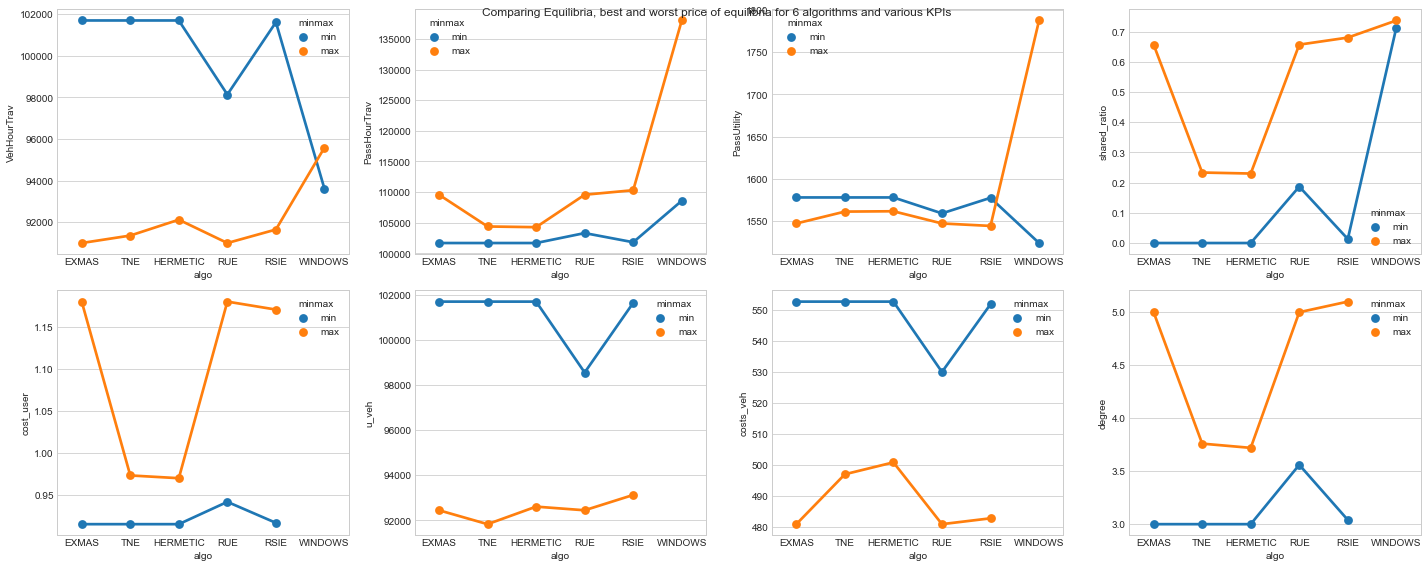

In [21]:
plot_KPIs('costs_user')

---
(c) Rafał Kucharski, Delft, 2020